In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree 
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 
from collections import Counter

import sys
sys.path.insert(0, '/Users/pauor506/Documents/PP_active_learning/')
import functions as fun

In [2]:
# Reading dataset (from https://www.kaggle.com/datasets/mathchi/diabetes-data-set?resource=download)
diabetes = pd.read_csv('/Users/pauor506/Documents/PP_active_learning/BasicClassification_easydataset/diabetes.csv')

diabetes['Glucose']=diabetes['Glucose'].replace(0,diabetes['Glucose'].mean())
diabetes['BloodPressure']=diabetes['BloodPressure'].replace(0,diabetes['BloodPressure'].mean())
diabetes['SkinThickness']=diabetes['SkinThickness'].replace(0,diabetes['SkinThickness'].mean())
diabetes['Insulin']=diabetes['Insulin'].replace(0,diabetes['Insulin'].mean())
diabetes['BMI']=diabetes['BMI'].replace(0,diabetes['BMI'].mean())

In [3]:
# Creating X and y sets
X_init = diabetes.drop(['Outcome'], axis=1).to_numpy() # I am using all the features for prediction
X = StandardScaler().fit_transform(X_init) # Scale the data 
y = diabetes['Outcome'].to_numpy()

In [19]:
# Models
knn = KNeighborsClassifier(n_neighbors = 5)
svmm = svm.SVC(random_state=0)
ada_clf = AdaBoostClassifier(random_state=0) #DecisionTreeClassifier initialized with max_depth=1 and 50 trees

models = [knn, svmm, ada_clf]


## Over-samplig the minority class

In [18]:
X_smote, y_smote = SMOTE(random_state=8472352).fit_resample(X, y)
X_ada, y_ada = ADASYN(random_state=4268934).fit_resample(X, y)

print(f'Original count: {sorted(Counter(y).items())}')
print(f'Smote count: {sorted(Counter(y_smote).items())}')
print(f'Adasyn count: {sorted(Counter(y_ada).items())}')


Original count: [(0, 500), (1, 268)]
Smote count: [(0, 500), (1, 500)]
Adasyn count: [(0, 500), (1, 509)]


In [20]:
cv_number = 10

kfold_validation=KFold(cv_number)
acc_cv_x_model_sm, f1_cv_x_model_sm = fun.train_x_modelList(models, X_smote, y_smote, kfold_validation)
acc_cv_x_model_ada, f1_cv_x_model_ada = fun.train_x_modelList(models, X_ada, y_ada, kfold_validation)

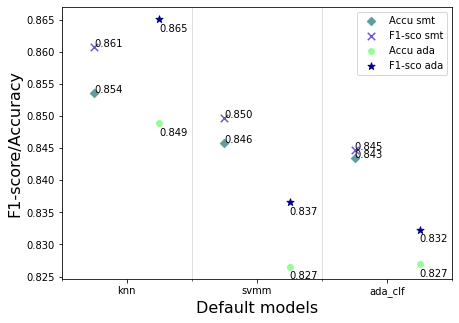

In [21]:
models_names =['knn', 'svmm', 'ada_clf']
fun.plot_score_comparision(acc_cv_x_model_sm, f1_cv_x_model_sm, acc_cv_x_model_ada, f1_cv_x_model_ada, models_names, ['smt', 'ada'], 0.002)


**Super nice!!! The F1-score improved a lot meanwhile the accuracy stay relatively the same**. Note that in (almost) all cases over-sampling the minority class with SMOTE gives the best perfomance so I will stick with it for the next expeiments. 
The next step from here:
1. Do hyperparameter tunning to increase the accuracy of the classifiers. We can continue using only accuracy because now the classes are balanced. 

## Under-sampling the majority class

In [22]:
X_rus, y_rus = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_enn, y_enn = EditedNearestNeighbours().fit_resample(X, y)

print(f'Original count: {sorted(Counter(y).items())}')
print(f'Smote count: {sorted(Counter(y_rus).items())}')
print(f'Adasyn count: {sorted(Counter(y_enn).items())}')

Original count: [(0, 500), (1, 268)]
Smote count: [(0, 268), (1, 268)]
Adasyn count: [(0, 273), (1, 268)]


In [23]:
cv_number = 10

kfold_validation=KFold(cv_number)
acc_cv_x_model_rus, f1_cv_x_model_rus = fun.train_x_modelList(models, X_rus, y_rus, kfold_validation)
acc_cv_x_model_enn, f1_cv_x_model_enn = fun.train_x_modelList(models, X_enn, y_enn, kfold_validation)

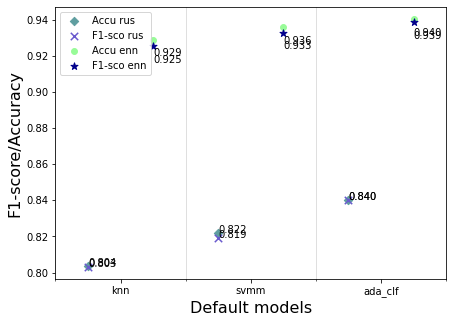

In [31]:
fun.plot_score_comparision(acc_cv_x_model_rus, f1_cv_x_model_rus, acc_cv_x_model_enn, f1_cv_x_model_enn, models_names, ['rus', 'enn'], 0.009)

Okay these results looks better than before BUT we shall remember that undersampling loses information since it removes points that may be relevant and useful. Hence, I will stick to oversampling and do some other stuff to improve the basic classifier.